<a href="https://colab.research.google.com/github/robpalinic/springboard-capstone-two/blob/main/Seattle_AirBnb_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

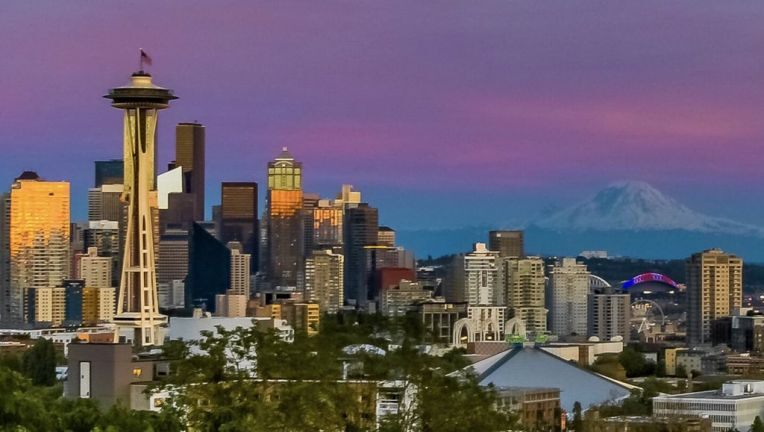

# **Optimizing the Seattle AirBnB market**

---


Hosts that have high occupancy rates (above 95%) may be underpricing their units, but may not know an ideal price to charge to optimize their revenue. Conversely, the rest of the market may have low occupancy due to factors under their control that they do not know about.

The goal is to create a model that will predict prices for listings that are not fully booked (below 95% occupancy), then compare predicted prices against actual prices for the top segment (above 95% occupancy).  Using this model, we can identify listings with high occupancy but are underpriced, and hopefully identify low occupancy homes which are either underpriced or could improve their pricing if the owners undertook some actions.

There are features which can impact the price: 
*   Location
*   Size of the unit
*   The inherent quality of the home
*   Actions of the owner, such as cleanliness, responsiveness, etc.
*   The whim of the owner in setting the price

This model will  not be able to capture either the inherent quality of the home, nor the whim of the owner in pricing.  As such, any R2 score will not approach 1 as we will be excluding a large amount of unobtainable information.

The deliverables of this project will be:

1.   Regression model (either a regular linear regression, random forest, XGBoost model)
2.   Analysis of high occupancy listings and the suitability of their pricing.
3.   Analysis of normal listings and the suitability of their pricing
4.   Identification of actionable featuers that normal listings can undertake to improve their pricing, if any.






## **Step 1: Data Collection**

---


Data was sourced from Kaggle, which had a dataset for one year for Seattle by listings from the year 2016.  Included is a separate file for reviews which is not needed for this analysis.

An important portion of this analysis will revolve around occupancy rates, which are not part of the data set. Analysis from insideairbnb.com, which analyzes AirBnB data, suggests that half of the guests leave reviews. Some data munging will most likely be necessary based on average reviews per month.

The original data: https://www.kaggle.com/airbnb/seattle

The Occupancy Model: http://insideairbnb.com/about.html#The%20Occupancy%20Model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_colwidth',200)

In [ ]:
listings = pd.read_csv('/content/drive/MyDrive/Seattle AirBnb/listings.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Seattle AirBnb/reviews.csv')

## **Step 2:  Data Definition**

---


Here we will get an idea of the data we have.  How many records, fields, data types, and what we are going to be able to use.

In our first step, we find that there are 92 fields (92!) and 3,818 records.  The fields can be broken into a few broad groups:
Host Information

*   Home Description and Characteristics
*   Reviews
*   Location
*   Pricing
*   Rules
*   Scraping information



Many of these fields are superfluous to building a model, or are redundant (three fields for neighbourhood, plus latitude and longtitude, etc.)  The obvious fields will be removed immediately during data cleansing, while the redundant fields will be examined and culled.












In [ ]:
listings.shape

(3818, 92)

In [ ]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [ ]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,"Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a dup...","Make your self at home in this charming one-bedroom apartment, centrally-located on the west side of Queen Anne hill. This elegantly-decorated, completely private apartment (bottom unit of a dup...",none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/cfe47d69_original.jpg?interpolation=lanczos-none&size=large_cover&output-format=jpg&output-quality=70,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a small landscape business. My life revolves around beauty wherever I find it or create it. I grew up in Seattle and love this city for the people, it's ...",within a few hours,96%,100%,f,"https://a0.muscache.com/ac/users/956883/profile_pic/1318103129/original.jpg?interpolation=lanczos-none&crop=w:w;*,*&crop=h:h;*,*&resize=50:*&output-format=jpg&output-quality=70","https://a0.muscache.com/ac/users/956883/profile_pic/1318103129/original.jpg?interpolation=lanczos-none&crop=w:w;*,*&crop=h:h;*,*&resize=225:*&output-format=jpg&output-quality=70",Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air Conditioning"",Kitchen,Heating,""Family/Kid Friendly"",Washer,Dryer}",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,"Chemically sensitive? We've removed the irritants triggering allergy or asthma attacks, like carpeting, forced air & used pillows, all culprits that harbor fungus, mold & bacteria. No smoking, no...","Beautiful, hypoallergenic apartment in an extremely safe, quiet and pedestrian-friendly section of Queen Anne. A leafy-green location that puts the best of Seattle at your doorstep. Free WiFi, fr...","Chemically sensitive? We've removed the irritants triggering allergy or asthma attacks, like carpeting, forced air & used pillows, all culprits that harbor fungus, mold & bacteria. No smoking, no...",none,"Queen Anne is a wonderful, truly functional village. You can walk everywhere... for coffee, for groceries, for a night out, for breathtaking views of the Puget Sound.","Wha

In [ ]:
reviews.head(1)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to everything!


In [ ]:
last= pd.to_datetime(reviews['date'])
reviews['year'] = last.dt.year
reviews['year'].value_counts()

2015    52493
2014    20365
2013     7077
2012     3251
2011     1169
2010      254
2016      223
2009       17
Name: year, dtype: int64

In [ ]:
reviews['month'] = last.dt.month
reviews['month'].value_counts()

8     13018
9     11677
7     10503
10     8955
6      8544
11     6665
5      5854
12     5732
4      4233
3      4158
1      2867
2      2643
Name: month, dtype: int64

In [ ]:
reviews = reviews[reviews['year']==2015]
reviews = reviews[reviews['month'].between(6,10)]
review_counts = pd.DataFrame(reviews.groupby('listing_id')['id'].count())
review_counts['listing_id'] = review_counts.index
review_counts.rename(columns={'listing_id':'id', 'id':'reviews'}, inplace=True)
review_counts.head(1)

,reviews,id
listing_id,,
4291,8,4291


The review file we will use will be called review_counts, and will be for the months of June to October in 2015 and contains the number of reviews by listing.


## **Step 3:  Data Cleansing**

---


The purpose of this step is identify records missing, unnecessary fields, fields that need formatting, and any categorical data which require changes.  I will be taking three different actions: removing fields, removing records, or altering records.

Cleansing will consist of several steps.  
, dealing with missing data, formatting of data, and outliers.

*   Removing unneeded fields
*   Formatting of data
*   Dealing with missing data
*   Removing Duplicates
*   Outliers




**3.0 Merge the listings file with review_counts**

In [ ]:
listings.shape

(3818, 92)

In [ ]:
listings = pd.merge(listings, review_counts)

**3.1 Initial fields to remove**
Any field that is redundant (geographic data), text heavy or about the host will be removed as it will not assist analysis.


In [ ]:
listings['amenities'].head(10)
#Looks to be TV, Internet, etc.  Will Remove this

0                                                                                         {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}
1    {TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit...
2    {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Fa...
3                      {TV,"Cable TV",Internet,"Wireless Internet",Kitchen,Heating,"Family/Kid Friendly","Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Fire Extinguisher",Essentials,Shampoo}
4                                                                                                               {"Wireless Internet","Free Parking on Premises",Heating,"Smoke Detec

In [ ]:
remove_fields = ['amenities', 'host_id', 'host_has_profile_pic', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'longitude', 'latitude', 'is_location_exact', 'host_neighbourhood',
                 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
                 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 
                 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 
                 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count', 
                 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'street', 'city', 
                 'state','calendar_updated', 'has_availability', 'calendar_last_scraped', 'requires_license', 
                 'license', 'jurisdiction_names', 'calculated_host_listings_count', 'availability_90', 'availability_60',
                 'availability_30', 'id', 'weekly_price', 'monthly_price']

In [ ]:
listings = listings.drop(remove_fields, axis=1)
listings.shape

(2721, 39)

**3.2 Formatting changes**

Several fields with dollar amounts need to be changed to float, while the percentage needs to be converted to float.

In [ ]:
fields_to_float = ['price',  'security_deposit', 'cleaning_fee', 'extra_people']

for f in fields_to_float:
  listings[f] = pd.to_numeric(listings[f].str.strip(',$'), errors='coerce')

In [ ]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'), errors='coerce')/100

**3.3 Dealing with missing data**
	

In [ ]:
listings.isna().sum().sort_values(ascending=False)

square_feet                         2642
security_deposit                    1362
cleaning_fee                         636
host_acceptance_rate                 414
host_response_time                   267
host_response_rate                   267
neighbourhood                        249
review_scores_checkin                 12
review_scores_cleanliness             12
review_scores_accuracy                12
bathrooms                             11
review_scores_value                   11
review_scores_location                10
review_scores_communication           10
review_scores_rating                   8
bedrooms                               3
property_type                          0
room_type                              0
accommodates                           0
neighbourhood_group_cleansed           0
beds                                   0
neighbourhood_cleansed                 0
host_is_superhost                      0
bed_type                               0
reviews         

**3.3.1 Square Feet**

Just about every record is missing this field.  Drop the field.

In [ ]:
listings = listings.drop(['square_feet'], axis=1)

**3.3.2 Security Deposit and Cleaning Fee**

Both of these fields should be set to zero for no fee.

In [ ]:
listings['security_deposit'].fillna(0, inplace=True)
listings['cleaning_fee'].fillna(0, inplace=True)

**3.3.3 Host Acceptance Rate**

In [ ]:
#Investigate acceptance rate field
print(listings['host_acceptance_rate'].head())
listings['host_acceptance_rate'].value_counts()

#This field is either 100%, or nothing. Will drop this field.

0    100%
1    100%
2    100%
3     NaN
4     NaN
Name: host_acceptance_rate, dtype: object


100%    2306
0%         1
Name: host_acceptance_rate, dtype: int64

In [ ]:
listings = listings.drop('host_acceptance_rate', axis=1)

**3.3.4 Review Score**

It looks like if some review scores are missing they are all missing.  Best to remove all of these records.

In [ ]:
listings[listings['review_scores_checkin'].isna()].head()

,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
269,within a few hours,0.99,f,Fremont,Wallingford,Other neighborhoods,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,259.0,0.0,155.0,1,0.0,3,1125,365,1,2015-09-16,2015-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,strict,f,f,0.27,1
534,NaN,NaN,f,University District,University District,University District,House,Private room,1,1.5,1.0,1.0,Real Bed,30.0,0.0,0.0,1,0.0,1,1125,180,1,2015-08-29,2015-08-29,80.0,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.23,1
560,within an hour,1.00,f,University District,University District,University District,Apartment,Entire home/apt,2,1.0,2.0,2.0,Real Bed,185.0,0.0,0.0,1,0.0,1,1125,365,1,2015-07-25,2015-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.18,1
573,within a day,1.00,f,University District,University District,University District,Apartment,Shared room,2,1.0,1.0,2.0,Real Bed,118.0,0.0,0.0,1,0.0,1,1125,365,1,2015-08-16,2015-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.21,1
1047,within a day,1.00,f,NaN,International District,Downtown,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,130.0,0.0,0.0,1,0.0,1,1125,72,1,2015-10-31,2015-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,0.45,1


In [ ]:
listings = listings[listings['review_scores_checkin'].notnull()]
listings.reset_index(inplace=True)
listings.shape

(2709, 38)

**3.3.5  Host Response Rate and Time**

Unknown why this data is missing, many of these listings are active.  I have to assume they just didn't have someone reach out.  Set these to 100% and 'Within an hour'

In [ ]:
listings['host_response_time'].value_counts()

within an hour        1311
within a few hours     705
within a day           409
a few days or more      22
Name: host_response_time, dtype: int64

In [ ]:
listings[listings['host_response_time'].isnull()].head(2)

,index,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
4,4,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Private room,2,1.0,1.0,1.0,Real Bed,120.0,0.0,40.0,1,30.0,1,6,302,17,2015-06-11,2015-09-28,95.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2.45,17
7,7,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,90.0,0.0,0.0,1,0.0,3,1125,341,8,2015-06-22,2015-08-17,97.0,10.0,9.0,10.0,9.0,10.0,10.0,f,strict,f,f,1.22,8


In [ ]:
listings['host_response_rate'].fillna(1, inplace=True)
listings['host_response_time'].fillna('within an hour', inplace=True)

**3.3.6 Last Review Time**
The data for the last review shows most listings had their reviews in 2015 or 2016.  Best to remove the older listings from 2014 and before.

In [ ]:
last= pd.to_datetime(listings['last_review'])
listings['year'] = last.dt.year
listings['year'].value_counts()

2015    2543
2016     166
Name: year, dtype: int64

In [ ]:
listings = listings[listings['year']>=2015]
listings['year'].value_counts()

2015    2543
2016     166
Name: year, dtype: int64

In [ ]:
listings = listings.drop(['first_review', 'last_review', 'year', 'index'], axis=1)

In [ ]:
print(listings.shape)

(2709, 35)


**3.3.7 Neighborhood**
The neighborhood field is missing values.  Luckily, there are two other neighborhood fields.  The neighborhood group cleansed field has 17 unique entries, while neighbourhood cleansed has 87.  I will be keeping the group field and dropping the other two.

In [ ]:
listings['neighbourhood_group_cleansed'].nunique()

17

In [ ]:
listings['neighbourhood_cleansed'].nunique()

87

In [ ]:
listings = listings.drop(['neighbourhood', 'neighbourhood_cleansed'], axis=1)
listings.shape

(2709, 33)

**3.3.8 Bathrooms, bedrooms, beds**

It is hard to believe there are no bathrooms, bedrooms, or beds in a listing.  Where the data is missing, we will enter a value of 1.

In [ ]:
listings.reset_index(drop=True, inplace=True)
listings['beds'].fillna(1, inplace=True)
listings['bedrooms'].fillna(1, inplace=True)
listings['bathrooms'].fillna(1, inplace=True)
print(listings.shape)

(2709, 33)


In [ ]:
listings.isna().sum().sort_values(ascending=False)

review_scores_value                 1
reviews                             0
bathrooms                           0
cleaning_fee                        0
security_deposit                    0
price                               0
bed_type                            0
beds                                0
bedrooms                            0
accommodates                        0
extra_people                        0
room_type                           0
property_type                       0
neighbourhood_group_cleansed        0
host_is_superhost                   0
host_response_rate                  0
guests_included                     0
minimum_nights                      0
reviews_per_month                   0
maximum_nights                      0
availability_365                    0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_scores_checkin               0
review_score

**3.3.9 Room Type**
To keep the analysis straightforward, I will keep only Entire home/apt.

In [ ]:
listings['room_type'].value_counts()

Entire home/apt    1797
Private room        837
Shared room          75
Name: room_type, dtype: int64

In [ ]:
listings=listings[listings['room_type']=='Entire home/apt']

**3.3.10 Recap:  What is the state of the data**
After all this, there is only one missing value in the review_scores_value field.  All of its reviews are 10s, so we will manually change the missing value to 10.

We are left with 1797records in 33 fields.

In [ ]:
listings.shape

(1797, 33)

In [ ]:
listings.isna().sum().sort_values(ascending=False)

review_scores_value                 1
reviews                             0
bathrooms                           0
cleaning_fee                        0
security_deposit                    0
price                               0
bed_type                            0
beds                                0
bedrooms                            0
accommodates                        0
extra_people                        0
room_type                           0
property_type                       0
neighbourhood_group_cleansed        0
host_is_superhost                   0
host_response_rate                  0
guests_included                     0
minimum_nights                      0
reviews_per_month                   0
maximum_nights                      0
availability_365                    0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_scores_checkin               0
review_score

In [ ]:
listings['review_scores_value'] = listings['review_scores_value'].fillna(10)

**3.4 Dedupe data**

It appears that there were no duplicates.

In [ ]:
print(listings.shape)
listings.drop_duplicates()
print(listings.shape)

(1797, 33)
(1797, 33)


**3.5 Check for outliers.**

Taking the minimum and maximum of each field, nothing sticks out as being too high or too low, except for one home with a price of $999.  It doesn't appear to be an error, so it is left in.  Perhaps a 'luxury' condo.

I did notice that a property type had a yurt.  I investigated and found some other weird property types (dorm, treehouse) that won't help with the modeling. These will be removed, leaving only House and Apartment.  Townhomes will be rolled up into House, while Condo and Loft will roll up into Apartment.

When we look at listings by neighbourhood, we find some neighbourhoods just have too few listings to justify analysis.  We can remove these from the dataset.

In [ ]:
listings.describe()

,host_response_rate,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,reviews
count,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.956316,4.050640,1.295771,1.462437,2.037284,156.776294,153.473567,62.598219,1.974958,12.469672,2.281024,773.539232,244.043406,28.420145,94.481358,9.657763,9.597106,9.788536,9.817474,9.633278,9.415136,2.102888,11.214802
std,0.106512,2.054978,0.603003,1.027114,1.262466,96.596946,173.554331,52.705415,1.512729,19.190662,2.213680,2396.670046,119.699086,38.311754,6.058853,0.619165,0.716612,0.570060,0.501740,0.618628,0.715836,1.808346,10.595601
min,0.170000,1.000000,0.000000,0.000000,1.000000,39.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,4.000000,4.000000,2.000000,2.000000,4.000000,4.000000,0.040000,1.000000
25%,0.990000,2.000000,1.000000,1.000000,1.000000,99.000000,0.000000,25.000000,1.000000,0.000000,1.000000,60.000000,144.000000,6.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.700000,3.000000
50%,1.000000,4.000000,1.000000,1.000000,2.000000,129.000000,100.000000,50.000000,2.000000,5.000000,2.000000,1125.000000,295.000000,15.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000,8.000000
75%,1.000000,5.000000,1.000000,2.000000,3.000000,177.000000,250.000000,90.000000,2.000000,20.000000,3.000000,1125.000000,354.000000,35.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.030000,17.000000
max,1.000000,16.000000,4.500000,7.000000,15.000000,999.000000,995.000000,300.000000,13.000000,300.000000,31.000000,100000.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000,63.000000


In [ ]:
listings[listings['price']==999]

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
862,within a few hours,1.0,f,Downtown,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,999.0,95.0,85.0,1,10.0,1,31,0,54,94.0,9.0,9.0,10.0,10.0,10.0,9.0,f,moderate,f,f,2.89,6


In [ ]:
listings['property_type'].value_counts()

Apartment          1014
House               641
Condominium          44
Townhouse            31
Loft                 23
Cabin                15
Camper/RV             7
Other                 7
Bungalow              5
Tent                  3
Bed & Breakfast       2
Boat                  2
Chalet                1
Yurt                  1
Treehouse             1
Name: property_type, dtype: int64

In [ ]:
listings.loc[(listings['property_type'] == 'Townhouse'),'property_type'] = 'House'
listings.loc[(listings['property_type'] == 'Bungalow'),'property_type'] = 'House'

listings.loc[(listings['property_type'] == 'Condominium'),'property_type'] = 'Apartment'
listings.loc[(listings['property_type'] == 'Loft'),'property_type'] = 'Apartment'

to_drop = ['Bed & Breakfast', 'Cabin', 'Other', 'Camper/RV', 'Tent', 'Boat', 'Dorm', 'Treehouse', 'Chalet', 'Yurt']

listings = listings[~listings['property_type'].isin(to_drop)]

In [ ]:
listings['neighbourhood_group_cleansed'].value_counts()

Downtown               345
Other neighborhoods    330
Capitol Hill           253
Queen Anne             168
Central Area           158
Ballard                111
West Seattle            93
Rainier Valley          46
University District     45
Cascade                 40
Beacon Hill             40
Northgate               30
Delridge                28
Magnolia                27
Lake City               22
Seward Park             20
Interbay                 2
Name: neighbourhood_group_cleansed, dtype: int64

In [ ]:
neighbourhood_change = ['Interbay', 'Seward Park', 'Magnolia', 'Lake City', 'Northgate', 'Cascade', 'Delridge']

listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].replace([neighbourhood_change],'Other neighborhoods')

listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    499
Downtown               345
Capitol Hill           253
Queen Anne             168
Central Area           158
Ballard                111
West Seattle            93
Rainier Valley          46
University District     45
Beacon Hill             40
Name: neighbourhood_group_cleansed, dtype: int64

I'm worried about the prevalence of price outliers skewing results.  I will drop everything above 400 as there seems to be other factors driving those prices. Turns out there were only 48 listings above 400.

In [ ]:
print(listings.shape)
listings = listings[listings['price']<=400]
print(listings.shape)

(1758, 33)
(1714, 33)


**3.6 Final Data Frame**

We are now left with 33 fields and 1714 records.  This represents ten Seattle neighbourhoods, broken down into homes or apartments.


In [ ]:
listings.shape

(1714, 33)

In [ ]:
listings.head()

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,reviews
0,within a few hours,0.96,f,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0.0,0.0,2,5.0,1,365,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,4.07,26
1,within an hour,0.98,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,100.0,40.0,1,0.0,2,90,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,1.48,17
8,within an hour,0.98,t,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150.0,100.0,40.0,1,0.0,2,365,324,32,97.0,10.0,10.0,10.0,10.0,10.0,9.0,f,strict,t,t,1.55,13
9,within a few hours,1.00,t,Queen Anne,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,95.0,0.0,15.0,2,15.0,3,7,153,181,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,t,f,3.33,35
10,within a few hours,1.00,f,Queen Anne,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,99.0,500.0,150.0,1,0.0,3,1125,229,8,97.0,10.0,10.0,9.0,10.0,10.0,9.0,f,strict,f,f,0.98,5




## **4.  Exploratory Data Analysis**

---



**4.1 Correlation between fields**

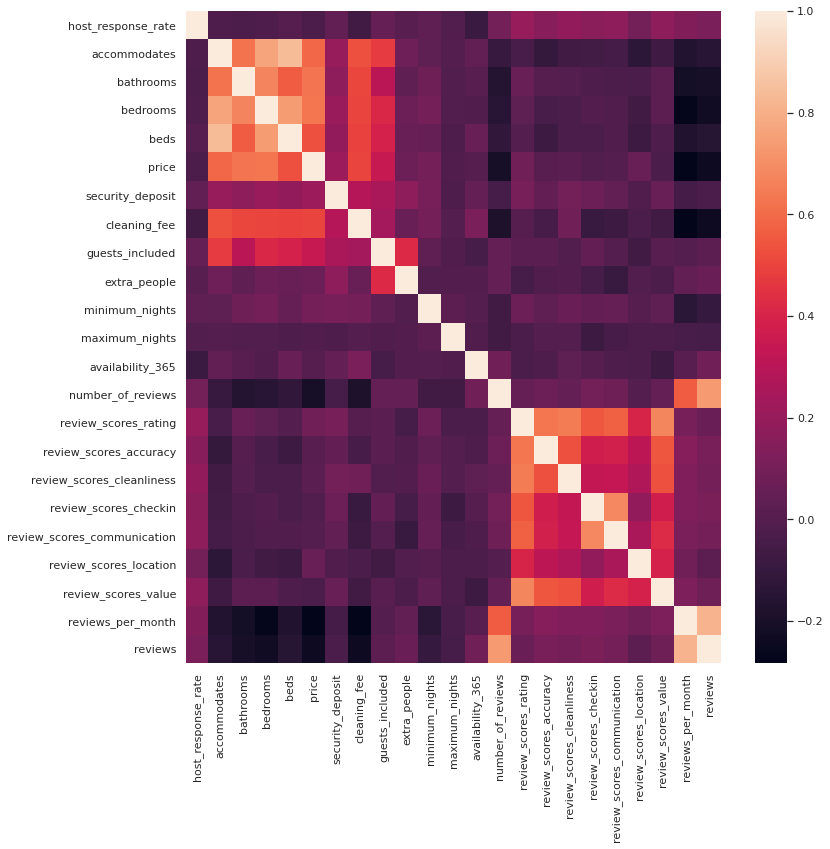

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(listings.corr())
plt.show()

No surprise, fields denoting the size of the dwelling show a high correlation, as does price.  Interestingly, cleaning fee is also highly correlated.  Another cluster of highly correlated variables are around the rview scores (except location).

Surprisingly, there does not appear to be any correlation between price and reviews scores. This is surprising, and needs a closer look.

---



**4.2 Price against review scores.**

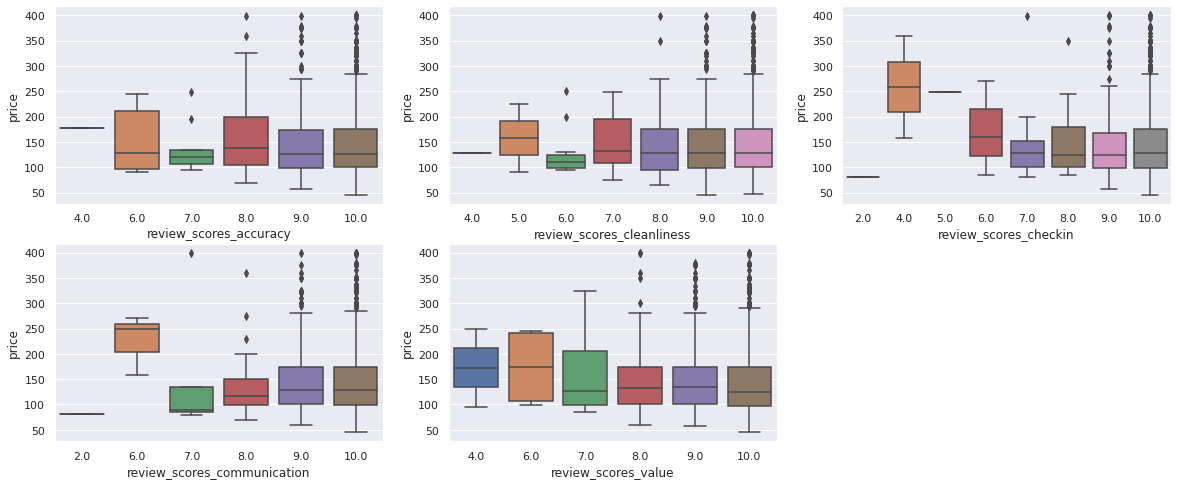

In [ ]:
listing_reviews = ['review_scores_accuracy', 'review_scores_cleanliness', 
           'review_scores_checkin', 'review_scores_communication', 'review_scores_value']

plt.figure(figsize=(20, 8))
plt.ylabel('Price')
i=1

for r in listing_reviews:
  plt.subplot(2, 3, i)
  sns.boxplot(x=listings[r], y=listings['price'])
  plt.xlabel(r)
  i+=1
plt.show()


It does appear that there is some correlation between review scores and price, with the most expensive listings tending to also have the best reviews and the cheaper listings have poorer reviews.  However, there are also many well reviewed homes that are cheap.  This may not be the best predictor.

---



**4.3 Let's compare pricing for homes vs apartments, and see if there is a difference.**

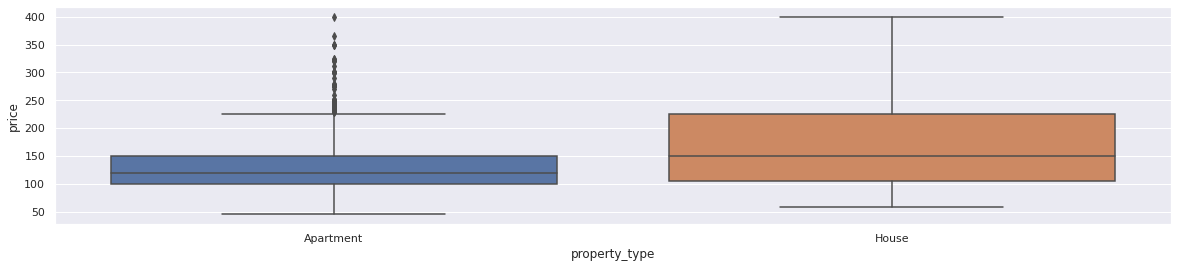

In [ ]:
plt.figure(figsize=(20,4))
sns.boxplot(x=listings["property_type"], y=listings["price"] );
plt.show()

Houses have a wider range of prices, but both apartments and houses have extremely pricey outliers at the high end of the range.  These may be super luxury types of homes, perhaps worth taking out.  Also, my assumption is that homes will be in suburbs (cheaper) while apartments will be in centralized areas.

**4.4 Now let's compare prices by neighbourhood.**

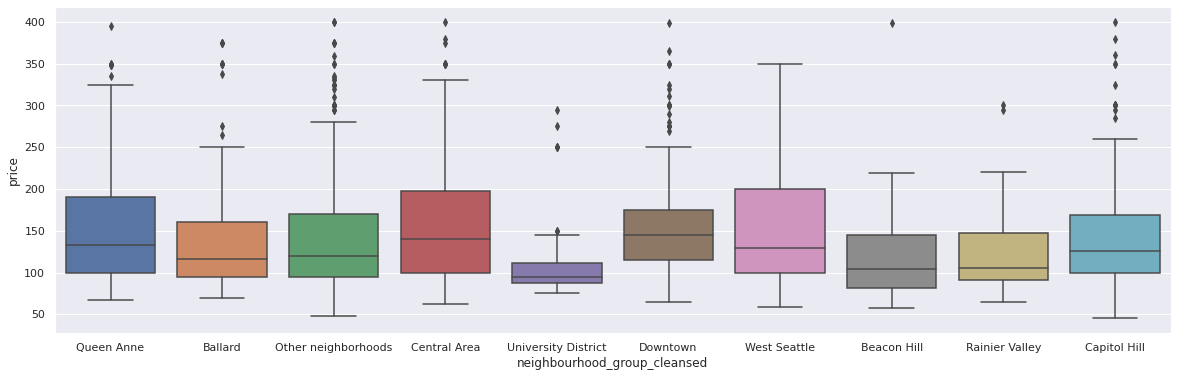

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x=listings["neighbourhood_group_cleansed"], y=listings["price"] );
plt.show()

It's making sense, with downtown neighbourhoods being fairly expensive and the university district being cheap.  Each neighbourhood has a noticeable number of outliers.  

**4.5 Finally, let's the reviews per month column against listings.**

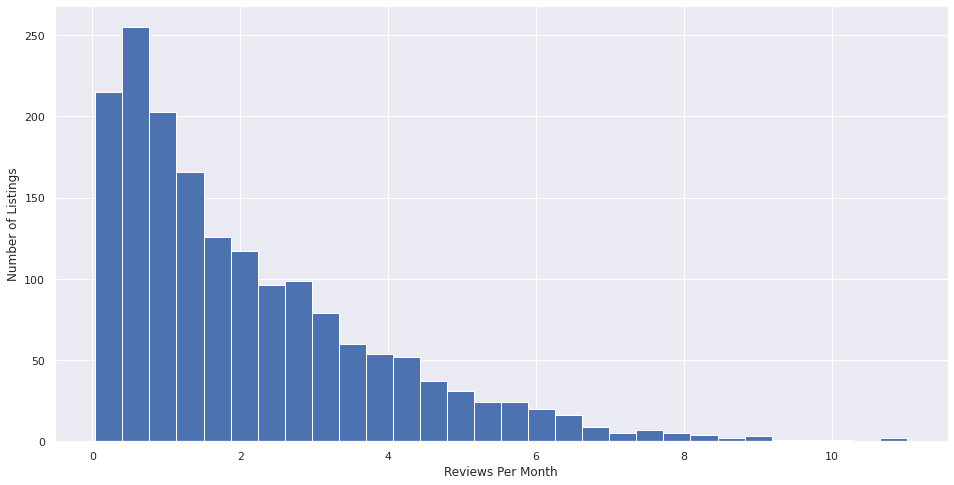

In [ ]:
plt.figure(figsize=(16,8))
plt.ylabel('Number of Listings')
plt.xlabel('Reviews Per Month')
plt.hist(listings['reviews_per_month'], bins=30)
plt.show()

This is interesting.  The idea of using a proxy of 50% of stays result in a review may be overstated.  Most listings have an average of 2 or less reviews.  I might need to go to the reviews file and use one month worth of data to see if I can get a more accurate count.  I don't know how the average reviews per month was calculated, as it could be number of reviews over a fixed time period, thereby underreporting the reviews.  Best to use a count from the reviews file. 

**4.6 Bedroom count and price.**

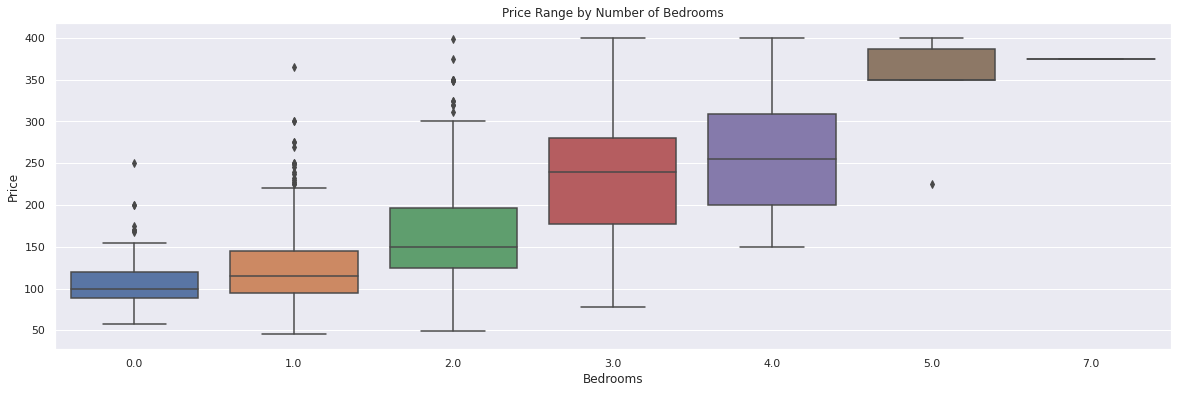

In [ ]:
plt.figure(figsize=(20,6))
plt.title('Price Range by Number of Bedrooms')
sns.boxplot(x=listings['bedrooms'], y=listings["price"] )
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

Not surprising that more bedrooms result in a higher price.  The lowest tier is zero bedrooms, but this is most likely studio apartments that are a combination bedroom, kitchen and living room.

**4.7  Reviews per month vs review count from Reviews file.**

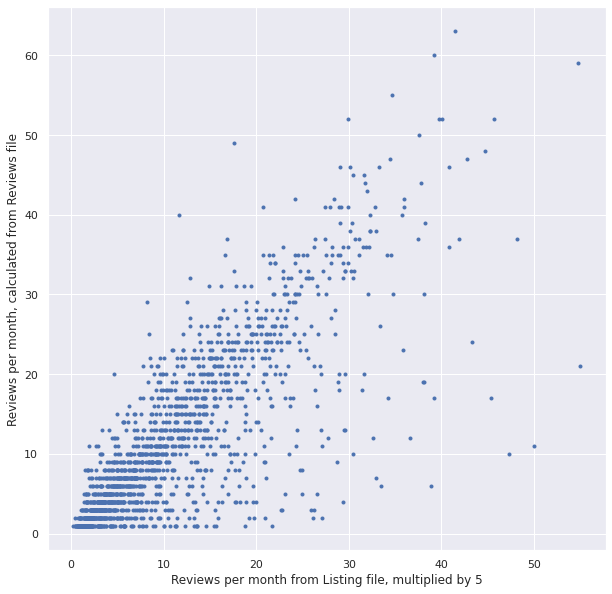

In [ ]:
plt.plot(listings['reviews_per_month']*5, listings['reviews'], linestyle='', marker='.')
plt.xlabel('Reviews per month from Listing file, multiplied by 5')
plt.ylabel('Reviews per month, calculated from Reviews file')
plt.show()

The original reviews_per_month correlates well with reviews, but not exactly.  I will use the new count as I feel it is more accurate.

In [ ]:
listings.drop('reviews_per_month', axis=1, inplace=True)

**Review count against listings.**

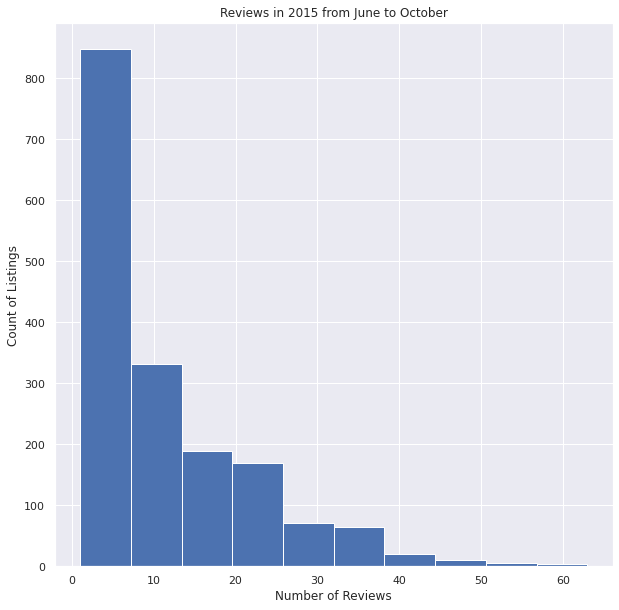

In [ ]:
plt.title('Reviews in 2015 from June to October')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Listings')
plt.hist(listings['reviews'])
plt.show()

Interesting that out of 150 possible days, most listings had ten or fewer reviews.  Assuming that the average stay is 5 days, we would still see the vast majority of listings not fully booked.

In [ ]:
listings[listings['reviews']>=27]['price'].count()

154

Assuming an average stay of 5 days, anything listing with over 27 listings can be considered over 90% occupied, by taking 150 potential rental days, dividing by 5 months to get 30 potential listings.  This gives us 284 listings out of 2584, or roughly 11% of listings.   I will add a flag called fully_booked.

In [ ]:
listings['fully_booked'] = np.where(listings['reviews']>=27, 'Yes', 'No')

Now, is there a difference in prices between fully booked and not fully booked listings?

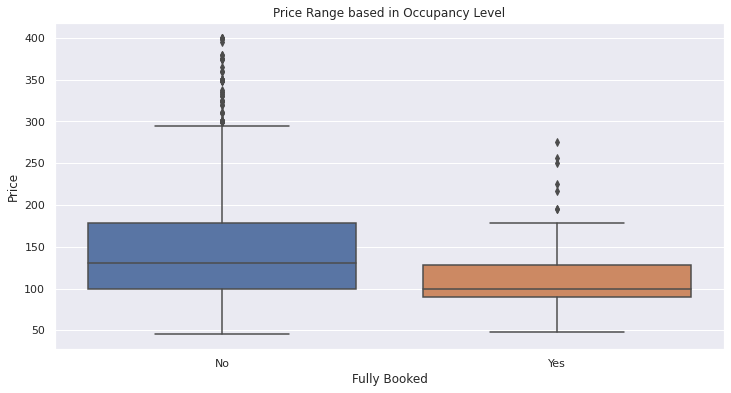

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Price Range based in Occupancy Level')
sns.boxplot(x=listings['fully_booked'], y=listings["price"] )
plt.xlabel('Fully Booked')
plt.ylabel('Price')
plt.show()

Interesting.  The price range for fully booked listings is noticeablly lower than the other listings.  This is at an aggregate of course, but may point to either lower prices driving quick booking, or hosts underselling their homes and leaving money on the table.



---


**4.8 EDA Conclusion**

We've explored the data and found that is in good shape.  We have identified pricing by ratings, neighbourhood, bedrooms, and house/apartment.  There is still a wide amount of variability in pricing, as well as occupancy rates as calculated from rating counts.  We're in great shape for the next stage of modeling.

The most noticeable conclusion is that high occupancy listings (with an estimated occupancy rate over 90%) have a lower price range than other homes.  This will be great for further modeling to determine if money is being left on the table.

## **5.  Data Preprocessing**

The goal of this stage is to:
Create dummy or indicator features for categorical variables

*   Create dummy or indicator features for categorical variables
*   Standardize the magnitude of numeric features using a scaler
*   Split the data into testing and training datasets


**5.1 Create dummy features for categorical variables**

In [ ]:
#Identify cateogrical variables
listings.select_dtypes(include='object').dtypes

host_response_time                  object
host_is_superhost                   object
neighbourhood_group_cleansed        object
property_type                       object
room_type                           object
bed_type                            object
instant_bookable                    object
cancellation_policy                 object
require_guest_profile_picture       object
require_guest_phone_verification    object
fully_booked                        object
dtype: object

In [ ]:
print(listings.shape)

dummies = list(listings.select_dtypes(include=object).columns)
listings = pd.get_dummies(listings, columns=dummies, drop_first=True)
print(listings.shape)

(1714, 33)
(1714, 45)


In [ ]:
list(listings.select_dtypes(exclude=object).columns)
#list(listings.select_dtypes(include=np.number).columns)

['host_response_rate',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_is_superhost_t',
 'neighbourhood_group_cleansed_Beacon Hill',
 'neighbourhood_group_cleansed_Capitol Hill',
 'neighbourhood_group_cleansed_Central Area',
 'neighbourhood_group_cleansed_Downtown',
 'neighbourhood_group_cleansed_Other neighborhoods',
 'neighbourhood_group_cleansed_Queen Anne',
 'neighbourhood_group_cleansed_Rainier Valley',
 'neighbourhood_group_cleansed_University District',
 'neighbourhood_group_cleansed_West Se

**5.2 Standardize the magnitude of numeric features using a scaler**

In [ ]:
listings.select_dtypes(include=['float64', 'int64']).dtypes

host_response_rate             float64
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
price                          float64
security_deposit               float64
cleaning_fee                   float64
guests_included                  int64
extra_people                   float64
minimum_nights                   int64
maximum_nights                   int64
availability_365                 int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
reviews                          int64
dtype: object

In [ ]:
scaler = StandardScaler()
price = listings['price']
names = listings.drop('price', axis=1).columns
scaled_df = scaler.fit_transform(listings.drop('price', axis=1))    
listings = pd.DataFrame(scaled_df, columns=names)
listings.head()

,host_response_rate,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_t,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_House,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t,fully_booked_Yes
0,0.039573,0.017769,-0.482732,-0.440049,-0.854438,-0.899395,-1.241747,0.051389,-0.381053,-0.570150,-0.169270,0.856233,4.768428,0.099541,0.557489,0.568293,0.378741,0.37109,-1.014635,0.825624,1.417275,-0.429558,1.670938,-1.159626,-0.591275,-0.15458,-0.407414,-0.315314,-0.496533,-0.633618,3.16025,-0.166066,-0.164202,-0.236789,-0.774838,-0.10302,-0.080369,0.133472,-0.482798,1.373143,-0.967845,-0.338281,-0.378720,-0.314194
1,0.225912,0.017769,-0.482732,-0.440049,-0.854438,-0.312690,-0.424061,-0.658934,-0.645926,-0.126153,-0.281501,0.398264,0.394942,0.264226,0.557489,0.568293,0.378741,0.37109,0.591168,0.825624,0.556464,-0.429558,-0.598466,0.862347,1.691260,-0.15458,-0.407414,-0.315314,-0.496533,-0.633618,3.16025,-0.166066,-0.164202,-0.236789,-0.774838,-0.10302,-0.080369,0.133472,-0.482798,-0.728256,1.033224,2.956118,2.640472,-0.314194
2,0.225912,0.017769,-0.482732,-0.440049,-0.854438,-0.312690,-0.424061,-0.658934,-0.645926,-0.126153,-0.169270,0.673046,0.101598,0.428912,0.557489,0.568293,0.378741,0.37109,0.591168,-0.571335,0.173881,-0.429558,-0.598466,0.862347,1.691260,-0.15458,-0.407414,-0.315314,-0.496533,-0.633618,3.16025,-0.166066,-0.164202,-0.236789,-0.774838,-0.10302,-0.080369,0.133472,-0.482798,-0.728256,1.033224,2.956118,2.640472,-0.314194
3,0.412251,-1.032447,-0.482732,-0.440049,-0.854438,-0.899395,-0.935115,0.051389,0.148694,0.317844,-0.315375,-0.750823,4.075070,0.428912,0.557489,0.568293,0.378741,0.37109,0.591168,0.825624,2.278087,-0.429558,1.670938,-1.159626,1.691260,-0.15458,-0.407414,-0.315314,-0.496533,-0.633618,3.16025,-0.166066,-0.164202,-0.236789,1.290593,-0.10302,-0.080369,0.133472,-0.482798,1.373143,-0.967845,2.956118,-0.378720,3.182746
4,0.412251,-1.032447,-0.482732,-0.440049,-0.854438,2.034134,1.824575,-0.658934,-0.645926,0.317844,0.140896,-0.117993,-0.538424,0.428912,0.557489,0.568293,-1.343176,0.37109,0.591168,-0.571335,-0.591285,-0.429558,1.670938,-1.159626,-0.591275,-0.15458,-0.407414,-0.315314,-0.496533,-0.633618,3.16025,-0.166066,-0.164202,-0.236789,1.290593,-0.10302,-0.080369,0.133472,-0.482798,-0.728256,1.033224,-0.338281,-0.378720,-0.314194


**5.3 Split the data into testing and training datasets**

In [ ]:
X= listings.loc[:, listings.columns!='price']
y = price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=55)

In [ ]:
full = X_test['fully_booked_Yes'].reset_index()

## **6.  Modeling**
The plan is to try three types of modeling:  a baseline dummy model, regression (OLS, Lasso, Ridge), Random Forests and XGBoost.  I will be comparing the R2 and MAE for each model and will investigate the top 5 features identified by importance.

In [ ]:
def mae(y, ypred):
    abs_error = np.abs(y-ypred)
    mae = np.mean(abs_error)
    return mae

In [ ]:
#Store the results and top features from each model in two dictionaries for later comparison.

results = {}
top_features = {}

def results_function(model, X_train, y_test, y_pred, coef):
  results[model] = {'R2': round(r2_score(y_test, y_pred),2), 
                    'MAE': round(mae(y_test, y_pred),2)}
  rf_feat_imps = pd.Series(coef, index=X_train.columns).sort_values(ascending=True)
  top_features[model] = list(pd.DataFrame(rf_feat_imps.sort_values(ascending=False)[:5]).index)

In [ ]:
#Create a scatter plot of predictions and test results.

def scatter_plot_pred_test(Model, y_test, y_pred):
  plt.title(Model)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.scatterplot(x=y_test, y=y_pred, hue=X_test['fully_booked_Yes'].values, palette=['Red', 'Blue'], legend=False)
  plt.xlabel('Test')
  plt.ylabel('Predict')
  ident = [50,400]
  plt.plot(ident,ident)
  plt.show()

In [ ]:
#Create a horizontal bar chart to show the importance of each feature to the model.

def feature_importance_bar(Model, coef, X_train=X_train):
  rf_feat_imps = pd.Series(coef, index=X_train.columns).sort_values(ascending=True)
  plt.figure(figsize=(16, 10))
  rf_feat_imps.plot(kind='barh')
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title(str(Model) + ' feature importance')

**6.1 Dummy Model**

In [ ]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)
dummy_regr.score(X_test, y_test)


-0.0020351238849423137

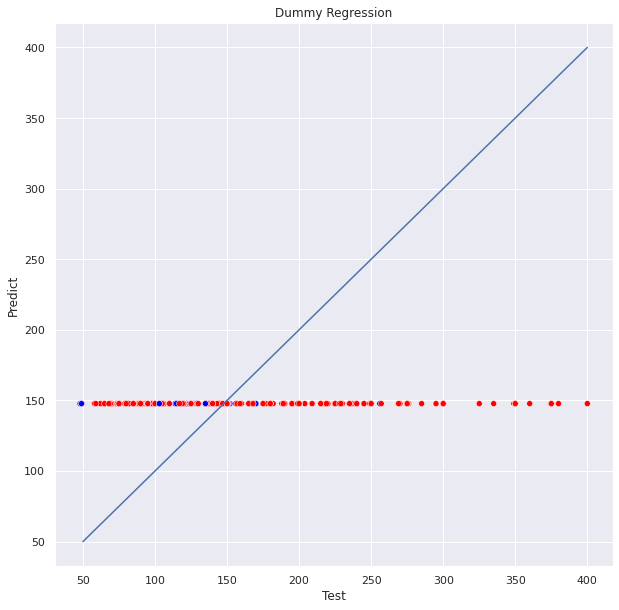

In [ ]:
scatter_plot_pred_test('Dummy Regression', y_test, y_pred)

In [ ]:
results['Dummy Regression'] = {'R2': round(r2_score(y_test, y_pred),2),
                               'MAE': round(mae(y_test, y_pred),2)}

**6.2.1 Linear Regression**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

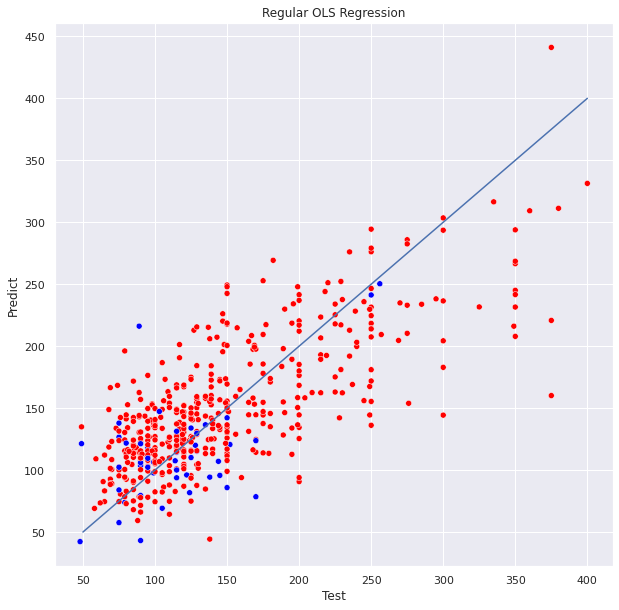

In [ ]:
scatter_plot_pred_test('Regular OLS Regression', y_test, y_pred)

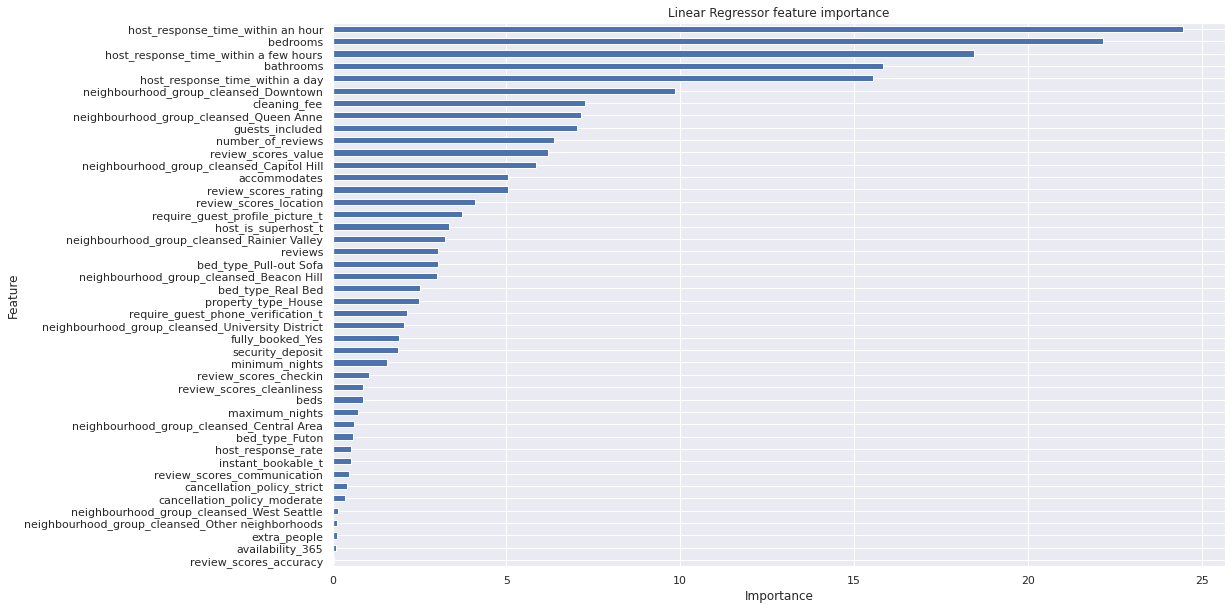

In [ ]:
feature_importance_bar('Linear Regressor', np.abs(lr.coef_))

In [ ]:
results_function('Linear Regression', X_train, y_test, y_pred, lr.coef_)

**6.2.2  Lasso Regression**

In [ ]:
lr_lasso = Lasso()
parameters = {'alpha': [.2, .3, .4, .5, .6, .7, ]}
clf = GridSearchCV(lr_lasso, parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model = Lasso(alpha=clf.best_params_['alpha'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

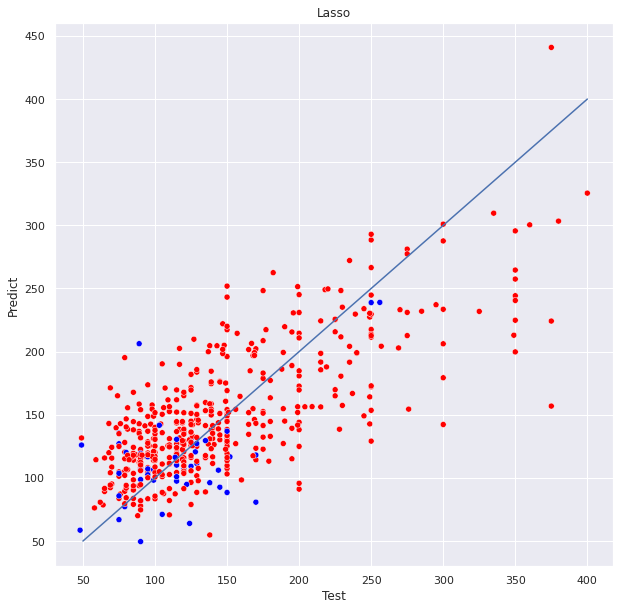

In [ ]:
plt.title("Lasso")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=y_test, y=y_pred, hue=X_test['fully_booked_Yes'].values, palette=['Red', 'Blue'], legend=False)
plt.xlabel('Test')
plt.ylabel('Predict')
ident = [50,400]
plt.plot(ident,ident)
plt.show()

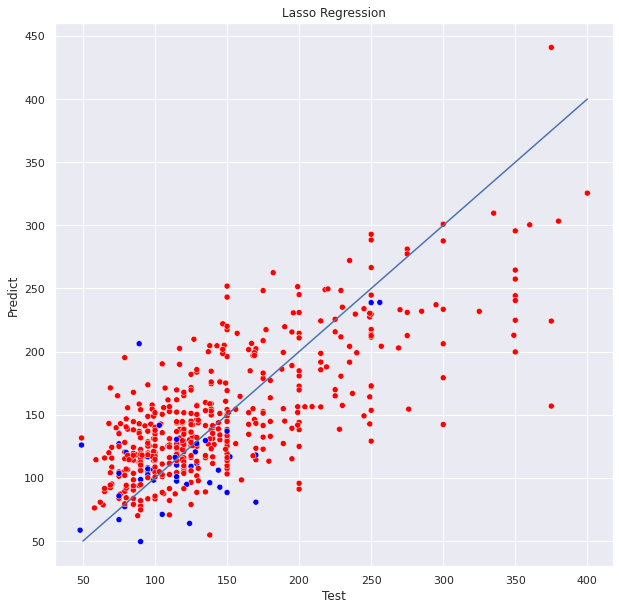

In [ ]:
scatter_plot_pred_test('Lasso Regression', y_test, y_pred)

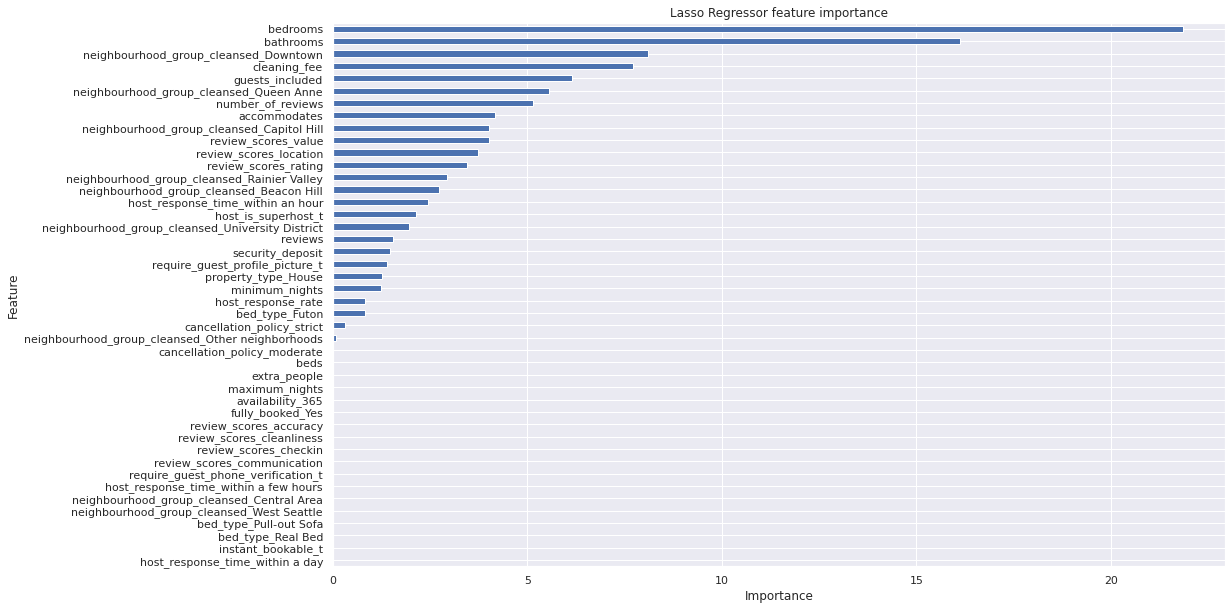

In [ ]:
feature_importance_bar('Lasso Regressor',  np.abs(model.coef_))

In [ ]:
results_function('Lasso Regression', X_train, y_test, y_pred, np.abs(model.coef_))

**6.2.3 Ridge Regression**

This will regularize coefficients so that outliers do not drive the model.

In [ ]:
lr_ridge = Ridge()
parameters = {'alpha': [.2, .3, .4, .5, .6, .7, ]}
clf = GridSearchCV(lr_ridge, parameters)
clf.fit(X_train, y_train)

model = Ridge(alpha=clf.best_params_['alpha'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

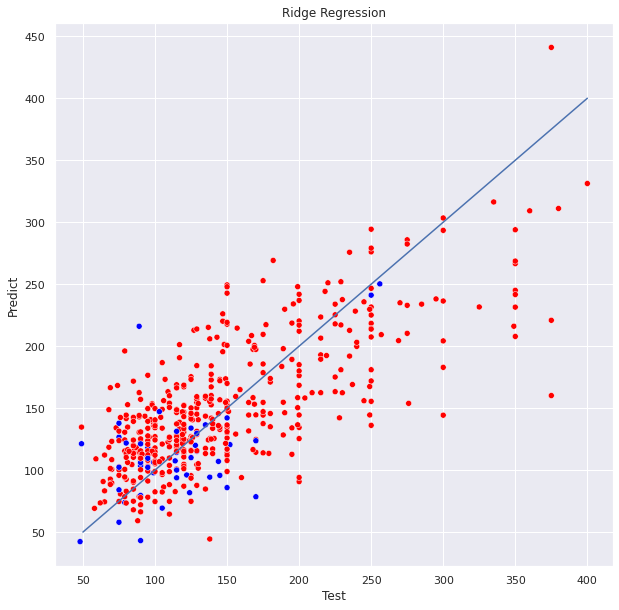

In [ ]:
scatter_plot_pred_test('Ridge Regression',  y_test, y_pred)

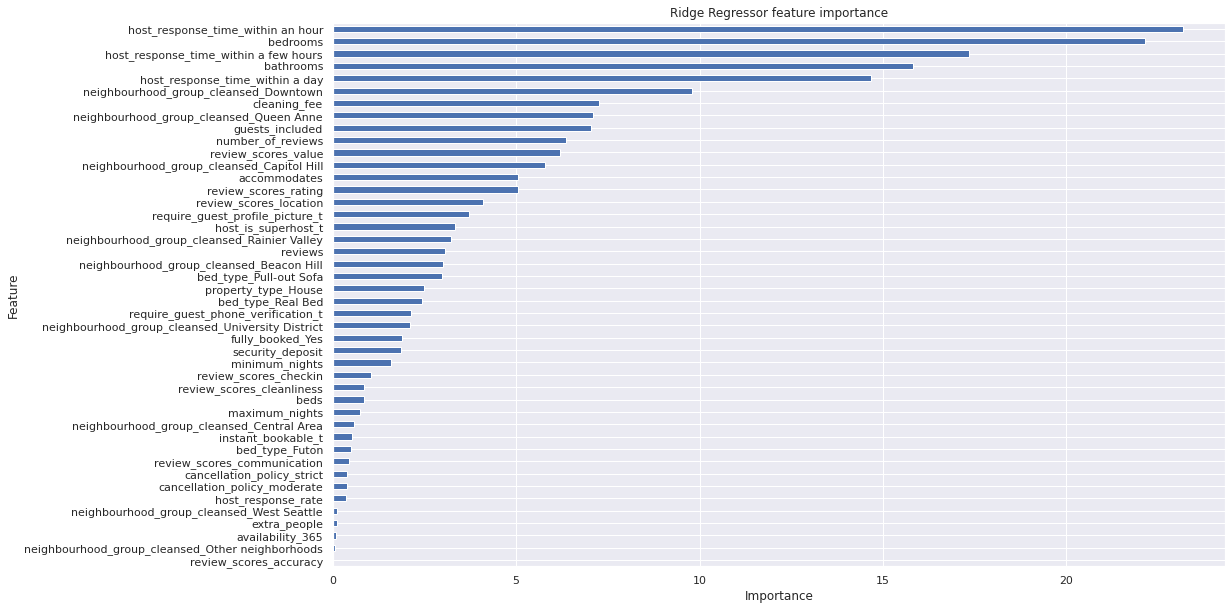

In [ ]:
feature_importance_bar('Ridge Regressor', np.abs(model.coef_))

In [ ]:
results_function('Ridge Regression', X_train, y_test, y_pred, np.abs(model.coef_))

**6.3 Random Forest**

In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=123, max_depth=10)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

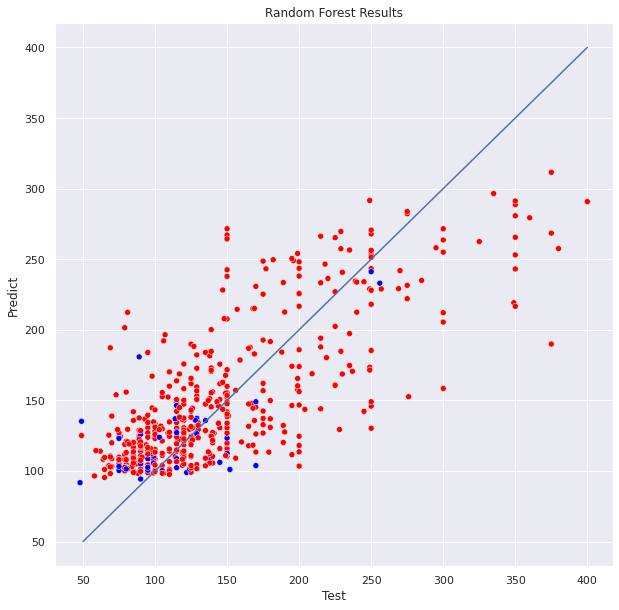

In [ ]:
scatter_plot_pred_test('Random Forest Results',  y_test, y_pred)

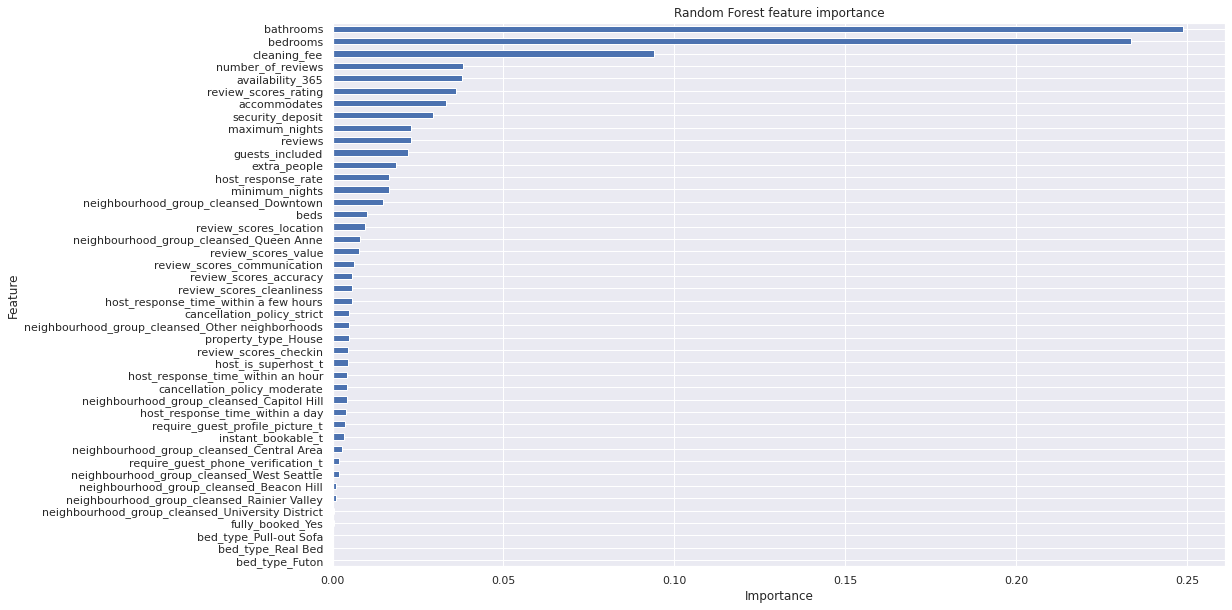

In [ ]:
feature_importance_bar('Random Forest', model.feature_importances_)

In [ ]:
results_function('Random Forest', X_train, y_test, y_pred, model.feature_importances_)

**6.4 XGBoost**

In [ ]:
# parameters = {'max_depth': np.arange(3, 7), 
#               'learning_rate': [0.15,  0.25], 
#               'n_estimators': np.arange(100, 500), 
#               'verbosity':[0]}

# xgb_reg = xgb.XGBRegressor()
# clf = GridSearchCV(xgb_reg, parameters)
# clf.fit(X_train, y_train)

# model = xgb.XGBRegressor(max_depth = clf.best_params_['max_depth'], 
#                          learning_rate = clf.best_params_['learning_rate'], 
#                          n_estimators = clf.best_params_['n_estimators'], 
#                          tree_method = "gpu_hist")
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(clf.best_params_)

In [ ]:


model = xgb.XGBRegressor(max_depth = 3, 
                         learning_rate = .15, 
                         n_estimators = 167, 
                         tree_method = "gpu_hist")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(clf.best_params_)

[21:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'alpha': 0.7}


{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 167, 'verbosity': 0}

In [ ]:
print(r2_score(y_test, y_pred))
print("MAE = " + str(round(mae(y_test, y_pred),2)))

0.609790634545105
MAE = 30.83


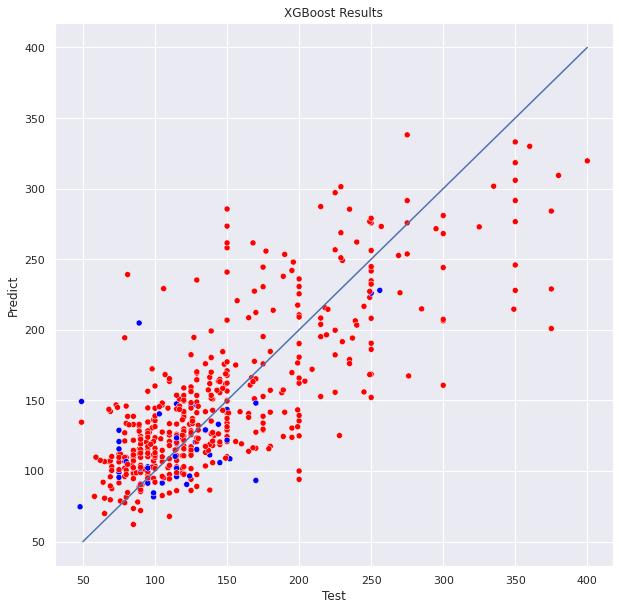

In [ ]:
scatter_plot_pred_test('XGBoost Results',  y_test, y_pred)

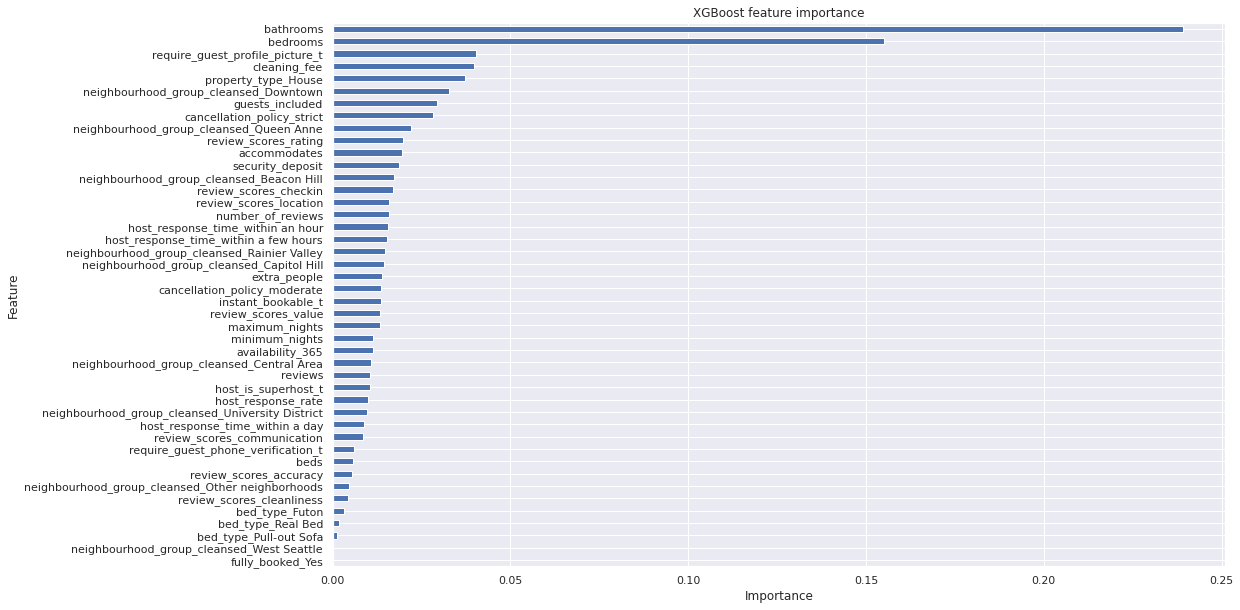

In [ ]:
feature_importance_bar('XGBoost', model.feature_importances_)

**6.5 Overall Modeling Results**

The three regression models had remarkably similar scores, both for R2 and MAE.  Surprisingly, Random Forest did worse, with a slightly lower R2 and a higher MAE.  The winner of the models was XGBoost, with a significant improvement in R2 and a significant lowering of MAE.  This is the model I will be utilizing.

The top five features were all similar.  Bedrooms and bathrooms were consistently important, as was cleaning fee.  The regression models all identified the neighbourhood as being important, while neither the Random Forest or XGBoost did so.  

Ridge Regression was the only model to show importance to host response times.

Apart from the model performance, it was also noticeable that at the low end, predictions were lower than actual values, while this somewhat reversed at the top end.  It would seem to indicate that low end listings are overcharging.

In [ ]:
results_function('XGBoost', X_train, y_test, y_pred, model.feature_importances_)
pd.DataFrame(results)

,Dummy Regression,Linear Regression,Lasso Regression,Ridge Regression,Random Forest,XGBoost
R2,-0.00,0.56,0.55,0.56,0.59,0.61
MAE,50.94,33.38,33.48,33.38,32.37,30.83


In [ ]:
pd.DataFrame(top_features)

,Linear Regression,Lasso Regression,Ridge Regression,Random Forest,XGBoost
0,bedrooms,bedrooms,host_response_time_within an hour,bathrooms,bathrooms
1,bathrooms,bathrooms,bedrooms,bedrooms,bedrooms
2,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Downtown,host_response_time_within a few hours,cleaning_fee,require_guest_profile_picture_t
3,cleaning_fee,cleaning_fee,bathrooms,number_of_reviews,cleaning_fee
4,neighbourhood_group_cleansed_Queen Anne,guests_included,host_response_time_within a day,availability_365,property_type_House
